In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

c:\Users\j0a02eu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load the data 

In [3]:
electronics_data=pd.read_csv("ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [4]:
electronics_data.head(3)

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600


In [5]:
electronics_data.shape

(7824482, 4)

In [6]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:1048576,0:]

In [7]:
#Check the datatypes
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [8]:
#Five point summary 

electronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [9]:
#Five point summary 

electronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [10]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [11]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


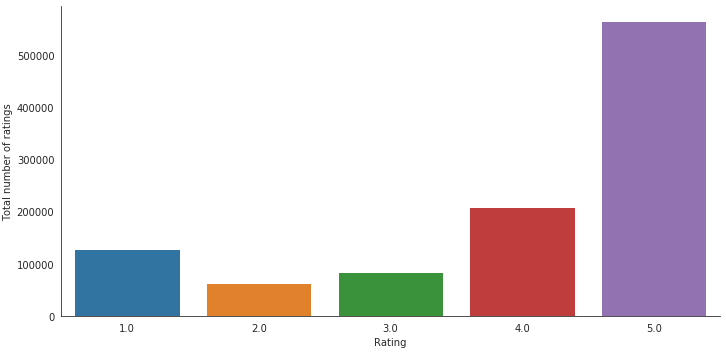

In [12]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [13]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users   : 786330
Total No of products  : 61894


In [14]:
#Dropping the Timestamp column

electronics_data.drop(['timestamp'], axis=1,inplace=True)

In [15]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [16]:
no_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [17]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [18]:
quantiles

0.00      1
0.01      1
0.02      1
0.03      1
0.04      1
       ... 
0.96      3
0.97      4
0.98      4
0.99      6
1.00    412
Name: Rating, Length: 101, dtype: int64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

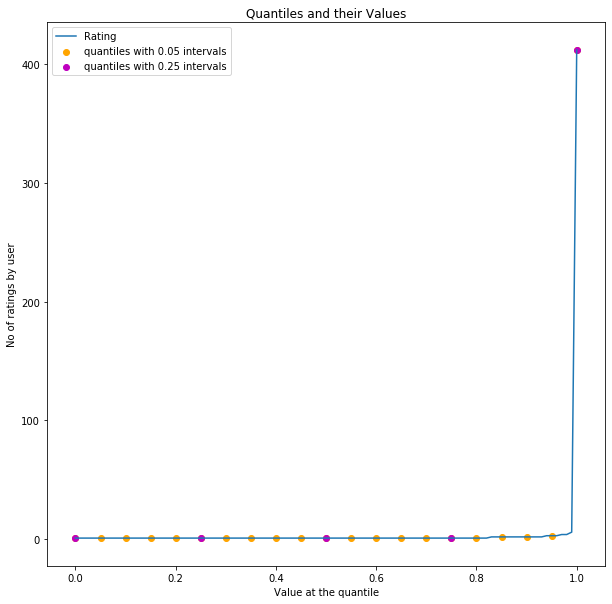

In [19]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [20]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



Popularity Based Recommendation

In [21]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [22]:
new_df
# f=electronics_data[electronics_data['userId']=='A1BKC6B7YHYTVV']
# f
# =='A1BKC6B7YHYTVV']

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0
...,...,...,...
1048571,A1H16CBCNEL4G3,B000IF51UQ,5.0
1048572,A1C2OANTC49AQI,B000IF51UQ,5.0
1048573,A2JL0387FDDFS,B000IF51UQ,5.0
1048574,A2KIYE5RF0OEMY,B000IF51UQ,4.0


Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

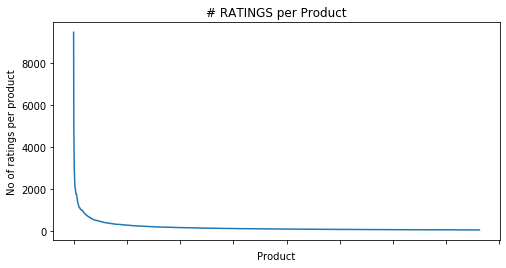

In [23]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [24]:
#Average rating of the product 

new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [25]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [26]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [27]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())
ratings_mean_count

,Rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211
...,...
B000IEN8QQ,4.531250
B000IEO964,4.533333
B000IF4788,4.189810


In [28]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [29]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [30]:
ratings_mean_count['rating_counts'].max()

9487

In [31]:
ratings_mean_count

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171
...,...,...
B000IEN8QQ,4.531250,64
B000IEO964,4.533333,60
B000IF4788,4.189810,1001


<Figure size 576x432 with 0 Axes>

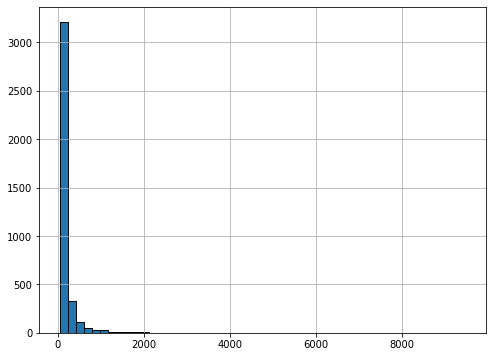

In [32]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

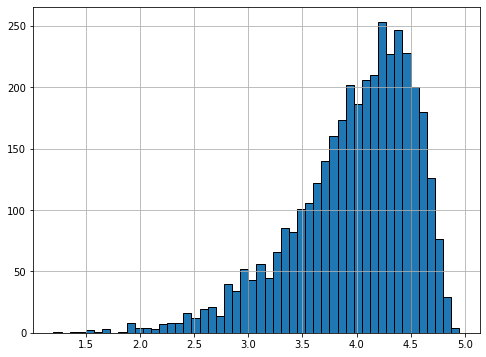

In [33]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

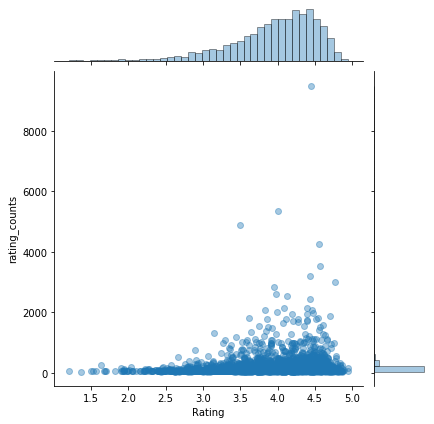

In [34]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

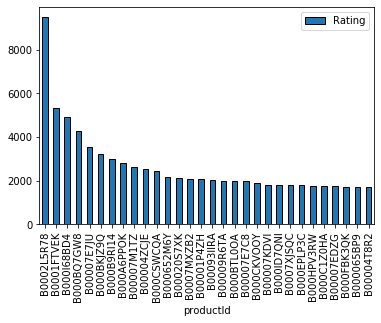

In [35]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

Collaberative filtering (Item-Item recommedation)

In [36]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

ModuleNotFoundError: No module named 'surprise'

In [ ]:
!pip install scikit-surprise

In [ ]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [ ]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

In [ ]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [ ]:
test_pred

In [ ]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Model-based collaborative filtering system

These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [37]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
ratings_matrix.shape

(9832, 76)

In [39]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X.shape

(76, 9832)

In [54]:
X.index

Index(['0972683275', '1400501466', '1400501520', '1400501776', '1400532620',
       '1400532655', '140053271X', '1400532736', '1400599997', '1400698987',
       '3744295508', '6301977173', '7214047977', '8862935293', '9573212919',
       '9575871979', '9625993428', '9888002198', '9966694544', '9983891212',
       '9984984354', '9985511476', 'B000001OM4', 'B000001OM5', 'B000001OMI',
       'B000001ON6', 'B00000DM9W', 'B00000IGBF', 'B00000J05A', 'B00000J061',
       'B00000J08Q', 'B00000J0D2', 'B00000J0D5', 'B00000J0D8', 'B00000J1EJ',
       'B00000J1EP', 'B00000J1EQ', 'B00000J1F3', 'B00000J1GA', 'B00000J1QK',
       'B00000J1QR', 'B00000J1SC', 'B00000J1TX', 'B00000J1U8', 'B00000J1UQ',
       'B00000J1V3', 'B00000J1V5', 'B00000J3NF', 'B00000J3Q7', 'B00000J3UJ',
       'B00000J434', 'B00000J4EY', 'B00000J4FS', 'B00000J4GE', 'B00000J6WY',
       'B00000JBAT', 'B00000JBHP', 'B00000JBPB', 'B00000JCT8', 'B00000JCTO',
       'B00000JD34', 'B00000JDF5', 'B00000JDF6', 'B00000JDHV', 'B00000JFE3',

In [41]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [42]:
decomposed_matrix

array([[ 1.48104508e+02, -1.54595579e-01,  2.45474539e-02,
         8.18018163e-05, -1.34183986e-01,  1.50151892e-04,
         4.60712512e-02, -8.49656709e-05,  1.28668658e-03,
        -8.31334934e-02],
       [ 6.67534158e-04,  1.28214255e+00,  1.47878315e+00,
         1.97849282e-01,  4.71135117e-03, -9.43303699e-04,
         1.00885680e-02,  2.72511790e-02,  6.14513988e+01,
        -2.87903757e-01],
       [ 2.96426462e-05,  1.05547045e-01,  3.11504431e-01,
         6.79639821e-03, -2.35636659e-03, -6.68888999e-03,
         1.97505996e-02,  1.71901513e-02,  1.55284033e+00,
        -2.00521955e-02],
       [ 5.38110774e-04,  7.50963476e-01,  4.80103769e-01,
        -7.60653292e-03,  1.63031382e-02, -4.87132754e-02,
         1.60396853e-02, -7.51186998e-02,  3.90375728e+00,
        -1.93313290e-01],
       [ 5.07609297e-04,  7.93466754e-01,  1.05978672e+00,
        -1.99008857e-02, -6.33859372e-03, -3.86901381e-02,
         2.33578499e-03, -1.76283827e-01,  8.04126409e-01,
        -2.

In [43]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [45]:
correlation_matrix

array([[ 1.        , -0.11626634, -0.14311663, ...,  0.06428376,
         0.13781797, -0.16087703],
       [-0.11626634,  1.        ,  0.98407713, ..., -0.96769784,
        -0.47467751,  0.86576524],
       [-0.14311663,  0.98407713,  1.        , ..., -0.94561524,
        -0.43496   ,  0.82384076],
       ...,
       [ 0.06428376, -0.96769784, -0.94561524, ...,  1.        ,
         0.58158673, -0.89781199],
       [ 0.13781797, -0.47467751, -0.43496   , ...,  0.58158673,
         1.        , -0.83584668],
       [-0.16087703,  0.86576524,  0.82384076, ..., -0.89781199,
        -0.83584668,  1.        ]])

In [57]:
correlation_matrix[75]

array([-0.16087703,  0.86576524,  0.82384076,  0.80627854,  0.21887584,
       -0.11715547, -0.23233094,  0.05052217,  0.94130193,  0.62633329,
       -0.4692181 , -0.83460165,  0.22581099,  0.51897897, -0.62515683,
        0.65386241, -0.64355628,  0.90210182,  0.97057108,  0.38179757,
        0.57135244, -0.36399664,  0.92111536, -0.4653527 , -0.19887896,
        0.41559231, -0.16081733, -0.95072262,  0.31063194, -0.20454819,
       -0.1810265 , -0.99351979,  0.70512973, -0.66251666, -0.7178879 ,
       -0.77678673, -0.6059373 , -0.35406477, -0.12714972, -0.83285906,
        0.05030133,  0.91023576,  0.7486597 ,  0.53652878,  0.21351516,
        0.6287799 , -0.13055801, -0.19384313, -0.54151513,  0.94666293,
       -0.93256658, -0.98361676, -0.91544542,  0.87061704,  0.86221627,
        0.19669321,  0.61641116, -0.20548351,  0.97946112,  0.94247672,
        0.37732486, -0.12900155, -0.16249549,  0.55282772,  0.82127824,
        0.0568571 , -0.87748301, -0.40447878, -0.16186238,  0.84

In [44]:
X.index[75]

'B00000K135'

In [49]:
product_ID

75

In [50]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [51]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [55]:
correlation_product_ID

array([-0.16087703,  0.86576524,  0.82384076,  0.80627854,  0.21887584,
       -0.11715547, -0.23233094,  0.05052217,  0.94130193,  0.62633329,
       -0.4692181 , -0.83460165,  0.22581099,  0.51897897, -0.62515683,
        0.65386241, -0.64355628,  0.90210182,  0.97057108,  0.38179757,
        0.57135244, -0.36399664,  0.92111536, -0.4653527 , -0.19887896,
        0.41559231, -0.16081733, -0.95072262,  0.31063194, -0.20454819,
       -0.1810265 , -0.99351979,  0.70512973, -0.66251666, -0.7178879 ,
       -0.77678673, -0.6059373 , -0.35406477, -0.12714972, -0.83285906,
        0.05030133,  0.91023576,  0.7486597 ,  0.53652878,  0.21351516,
        0.6287799 , -0.13055801, -0.19384313, -0.54151513,  0.94666293,
       -0.93256658, -0.98361676, -0.91544542,  0.87061704,  0.86221627,
        0.19669321,  0.61641116, -0.20548351,  0.97946112,  0.94247672,
        0.37732486, -0.12900155, -0.16249549,  0.55282772,  0.82127824,
        0.0568571 , -0.87748301, -0.40447878, -0.16186238,  0.84

In [52]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['1400501466',
 '1400501520',
 '1400501776',
 '1400599997',
 '9575871979',
 '9888002198',
 '9966694544',
 'B000001OM4',
 'B00000J0D5',
 'B00000J1SC',
 'B00000J1TX',
 'B00000J3UJ',
 'B00000J4GE',
 'B00000J6WY',
 'B00000JCT8',
 'B00000JCTO',
 'B00000JFE3',
 'B00000JII6']